In [54]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [55]:
### Load the data

bidder_data = pd.read_csv('datasets/bidder_data.csv')

bta_data = pd.read_csv('datasets/bta_data.csv')

bta_adjacency = pd.read_csv('datasets/btamatrix_merged.csv',  header=None)
bta_adjacency = bta_adjacency.drop(bta_adjacency.columns[0], axis=1)
bta_adjacency_j_j = bta_adjacency.values

geo_distance = pd.read_csv('datasets/distancesmat_dio_perl_fixed.dat', delimiter=' ', header=None)
geo_distance = geo_distance.drop(geo_distance.columns[-1], axis=1)
geo_distance_j_j = geo_distance.values

# travel_data = pd.read_csv('datasets/air-travel-passengers-bta-year-1994.csv')

travel_survey_0 = pd.read_csv('datasets/american-travel-survey-1995-zero.csv')
zero_row = pd.DataFrame(np.zeros((1, travel_survey_0.shape[1])), columns=travel_survey_0.columns)
travel_survey = pd.concat([zero_row, travel_survey_0], ignore_index=True)
travel_survey_j_j = travel_survey.values

In [56]:
bidder_data[bidder_data['co_name'].str.contains('Next')]

,bidder_num_fox,bidder_num,co_name,pops_eligible,bta,City,State,Applicant_Status,Legal_Classification
76,77,2146,NextWave Personal Communications Inc.,176055555.6,402,Solana Beach,CA,NaN,Corporation


In [57]:
bidder_data[bidder_data["pops_eligible"] > 176055555.6]

,bidder_num_fox,bidder_num,co_name,pops_eligible,bta,City,State,Applicant_Status,Legal_Classification
247,248,2372,U.S. AirWaves Holdings Inc.,180611430.0,413,Bellevue,WA,NaN,Corporation


In [58]:
### Weights and Capacities

# Reduce encoding lenght of weights and capacities
def round_weights(tick):

        capacity_i = bidder_data['pops_eligible'].to_numpy()
        weight_j = bta_data['pop90'].to_numpy()

        weight_j_rounded = (np.round((weight_j / tick) )).astype(int)
        capacity_i_rounded = (np.round((capacity_i / tick)) ).astype(int)

        return weight_j_rounded, capacity_i_rounded

weight_j, capacity_i = round_weights(5000)

### Matching matrix
def generate_matching_matrix():
    num_agents = len(capacity_i)
    num_objects = len(weight_j)
    matching_i_j = np.zeros((num_agents, num_objects), dtype=bool)

    for j in range(num_objects):
        winner_id = bta_data['bidder_num_fox'].values[j] - 1
        matching_i_j[winner_id, j] = True
        
    return matching_i_j

matching_i_j = generate_matching_matrix()

In [59]:
capacity_i.argmax()

np.int64(247)

In [60]:
bidder_data['pops_eligible']

0      3.777778e+06
1      4.222222e+05
2      3.166330e+05
3      2.412161e+06
4      7.944667e+04
           ...     
250    2.666667e+06
251    1.111111e+06
252    2.582988e+06
253    5.706730e+05
254    2.512578e+05
Name: pops_eligible, Length: 255, dtype: float64

In [61]:
delta = 4
E_j_j =  (weight_j[:, None] * weight_j[None,:]).astype(float)
np.fill_diagonal(E_j_j,0)
E_j_j[geo_distance_j_j> 0] /= (geo_distance_j_j[geo_distance_j_j> 0])**delta
pop_centroid_j_j = (weight_j[:, None] / weight_j.sum()) * (E_j_j / E_j_j.sum(1)[:,None])

print(pop_centroid_j_j.sum())

winning = np.unique(np.where(matching_i_j)[0])
pop_centroid_hat_i = (pop_centroid_j_j[None,:,:] * matching_i_j[:, :, None] * matching_i_j[:, None, :]).sum((1,2))
print('mean ', pop_centroid_hat_i[winning].mean())
print('std ', pop_centroid_hat_i[winning].std())
print('max ', pop_centroid_hat_i[winning].max())

1.0000000000000002
mean  0.005403268466952944
std  0.022615800358112514
max  0.19408515928907646


In [62]:
percentile = np.percentile(pop_centroid_j_j, 97)
print('percentile:', percentile)
truncated_pop_centroid_j_j= np.where(pop_centroid_j_j > percentile, pop_centroid_j_j, 0)
print(truncated_pop_centroid_j_j.sum())
winning = np.unique(np.where(matching_i_j)[0])
truncated_pop_centroid_hat_i = (truncated_pop_centroid_j_j[None,:,:] * matching_i_j[:, :, None] * matching_i_j[:, None, :]).sum((1,2))
print('mean ',truncated_pop_centroid_hat_i[winning].mean())
print('std ',truncated_pop_centroid_hat_i[winning].std())
print('max ',truncated_pop_centroid_hat_i[winning].max())
print('density:', np.count_nonzero(truncated_pop_centroid_j_j) / truncated_pop_centroid_j_j.size)

percentile: 3.2584275833492505e-06
0.9809025288536218
mean  0.005384417242563172
std  0.022547579813861768
max  0.19349275342339017
density: 0.030002180630243284


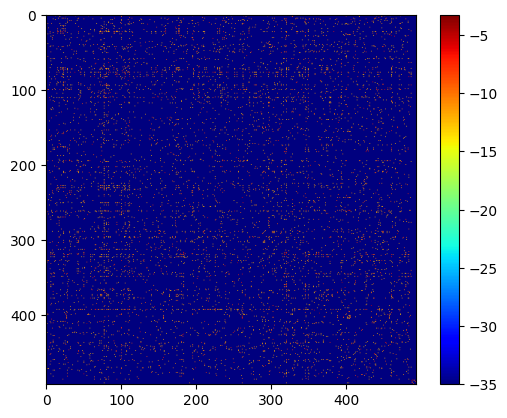

In [63]:
# plot heat map of pop_centroid_j_j
log_truncated_pop_centroid_j_j = truncated_pop_centroid_j_j.copy()
log_truncated_pop_centroid_j_j[truncated_pop_centroid_j_j > 0] = np.log(log_truncated_pop_centroid_j_j[truncated_pop_centroid_j_j > 0])
log_truncated_pop_centroid_j_j[truncated_pop_centroid_j_j == 0] = -35
plt.imshow(log_truncated_pop_centroid_j_j, cmap ='jet')
plt.colorbar()
plt.show()

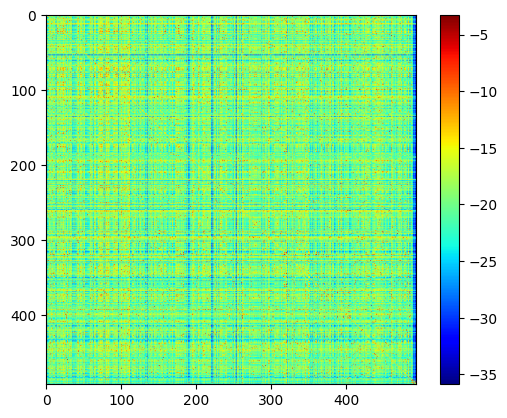

In [64]:
# plot heat map of pop_centroid_j_j
log_pop_centroid_j_j = pop_centroid_j_j.copy()
log_pop_centroid_j_j[pop_centroid_j_j > 0] = np.log(log_pop_centroid_j_j[pop_centroid_j_j > 0])
log_pop_centroid_j_j[pop_centroid_j_j == 0] = -14
plt.imshow(log_pop_centroid_j_j, cmap='jet')
plt.colorbar()
plt.show()

### Build characteristics matrices

In [65]:
geo_distance_j_j[bidder_data['bta'].to_numpy() - 1].shape

(255, 493)

In [66]:
### Modular Characteristics
modular_list = []

# 1. eligibility_i * pop_j  
modular_list.append((capacity_i[:, None]/ weight_j.sum() )* (weight_j[None, :]/ weight_j.sum()))

# 2. geo_distance between bidder's bta and bta
bidder_bta = bidder_data['bta'].to_numpy() - 1
modular_list.append( geo_distance_j_j[bidder_bta] /geo_distance_j_j[bidder_bta].sum(1)[:,None])

# 3. Rural status_i * density_j
rural_i = bidder_data['Applicant_Status'].str.contains('Rural Telephone Company', na=False).to_numpy()
density_j = bta_data['density'].to_numpy()
# modular_list.append(rural_i[:, None] * density_j[None, :])

# Stack 
modular_characteristics_i_j_k = np.stack(modular_list, axis=2)

### Quadratic Characteristics

quadratic_list = []
# BTA adjacency matrix
quadratic_list.append(bta_adjacency_j_j / bta_adjacency_j_j.sum())

second_order_adjacency = (bta_adjacency_j_j @ bta_adjacency_j_j > 0)
# quadratic_list.append(second_order_adjacency / second_order_adjacency.sum())

# Truncated pop weighted centroid
quadratic_list.append(truncated_pop_centroid_j_j)

# Travel survey

quadratic_travel_j_j = travel_survey_j_j.copy()

np.fill_diagonal(quadratic_travel_j_j, 0)
outflow_j = quadratic_travel_j_j.sum(1)
quadratic_travel_j_j[outflow_j > 0] /= outflow_j[outflow_j > 0][:, None]
quadratic_travel_j_j *= weight_j[:, None] / weight_j.sum()

quadratic_list.append(quadratic_travel_j_j)

 

# Stack
quadratic_characteristic_j_j_k = np.stack(quadratic_list, axis=2)
print('Density of quadratic term: ',(quadratic_characteristic_j_j_k.sum(2) > 0).sum() / quadratic_characteristic_j_j_k.sum(2).size)


# Compute characteristics at observed matching
phi_hat_i_k = np.concatenate(((modular_characteristics_i_j_k * matching_i_j[:, :, None]).sum(1),
                np.einsum('jlk,ij,il->ik', quadratic_characteristic_j_j_k, matching_i_j, matching_i_j)), 
                axis = 1)
phi_hat = phi_hat_i_k.sum(0)
print('phi_hat: ')
print(phi_hat)

print('std:', phi_hat_i_k.std(0))

Density of quadratic term:  0.0546721031561537
phi_hat: 
[0.34387222 0.6768488  0.30434783 0.47382872 0.24428296]
std: [0.01636328 0.01147164 0.00456814 0.01349066 0.01063082]


In [67]:
winning = np.unique(np.where(matching_i_j)[0])
pop_hat = (matching_i_j * weight_j[None, :] ).sum(1)/ weight_j.sum()

print('Statistics at winning bids')

print('Population')
print('mean:', pop_hat[winning].mean())
print('std:', pop_hat[winning].std())


print("--------------------")
print('elig * pop')
print('mean:', phi_hat_i_k[winning,0].mean())
print('std:', phi_hat_i_k[winning,0].std())


print("--------------------")
print('truncated pop centroid')
print('mean:', phi_hat_i_k[winning,-2].mean())
print('std:', phi_hat_i_k[winning,-2].std())
print('max:', phi_hat_i_k[winning,-2].max())


print("--------------------")
print('travel survey')
print('mean:', phi_hat_i_k[winning,-1].mean())
print('std:', phi_hat_i_k[winning,-1].std())
print('max:', phi_hat_i_k[winning,-1].max())

Statistics at winning bids
Population
mean: 0.011363636363636364
std: 0.04253848328951191
--------------------
elig * pop
mean: 0.003907638914029477
std: 0.02767464581986044
--------------------
truncated pop centroid
mean: 0.005384417242563172
std: 0.022547579813861768
max: 0.19349275342339017
--------------------
travel survey
mean: 0.002775942696627601
std: 0.01795656751044161
max: 0.16636405823284575


### Errors

In [68]:
num_simulations = 50
num_agents = len(capacity_i)
num_objects = len(weight_j)

np.random.seed(42)
epsilon_si_j = np.random.normal(0, 1, (num_simulations * num_agents, num_objects ))

# Save

In [ ]:
def save_instance_data(destination_path):
    np.save(destination_path + 'matching_i_j.npy', matching_i_j)
    np.save(destination_path + 'weight_j.npy', weight_j)
    np.save(destination_path + 'capacity_i.npy', capacity_i)

    np.save(destination_path + 'quadratic_characteristic_j_j_k.npy', quadratic_characteristic_j_j_k)
    np.save(destination_path + 'modular_characteristics_i_j_k.npy', modular_characteristics_i_j_k)
    np.save(destination_path + 'epsilon_si_j.npy', epsilon_si_j)


destination_path = 'GMM_quad_v2-50'

# save_instance_data(destination_path+'/data/')
print(np.load(destination_path + '/data/quadratic_characteristic_j_j_k.npy').shape)
print(np.load(destination_path + '/data/modular_characteristics_i_j_k.npy').shape)

(493, 493, 3)
(255, 493, 2)


# Pricing

In [63]:
capacity_i[76]

np.int64(35211)

In [64]:
print(quadratic_characteristic_j_j_k.shape)
print(modular_characteristics_i_j_k.shape)


(493, 493, 3)
(255, 493, 2)


In [67]:
from pricing_notebook import pricing

id = 76

lambda_k = np.array([1,1,1,1])

p_j = np.random.randint(0, 10, num_objects).astype(float)

solution = np.concatenate((p_j, np.zeros( num_agents),lambda_k))




In [68]:
pricing(modular_characteristics_i_j_k[id], quadratic_characteristic_j_j_k, weight_j,capacity_i[id],solution)


array([6.72852909, 0.42831976, 0.54833012, 0.31934033, 0.40019727,
       0.30540784, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     